In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore') # isto é só para não mostrar os eventuais warnings aqui no notebook

In [2]:
# Load your dataset
data = pd.read_csv('PhageAcr_ML_dataset_cdhit.csv')             # Read dataset
data.set_index('ID', inplace=True)                              # Set the "ID" column as the index
data = data.rename(columns={'Protein Acr': 'Protein_Acr'})  # Renaming columns to avoid issues later

# Extracting features (X) and target variable (y)
X = data.drop('Protein_Acr', axis=1)    # Keep only the features in variable x
y = data['Protein_Acr']                 # Assign our Target variable as y

# Split the dataset into training+validation (80%) and test sets (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # random_state will allow for the reproductibility of the split

# Split the training+validation set into training (70%) and validation sets (10% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

# Define the preprocessing and model pipeline
pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),       # Handle missing values
                     ('selector', SelectKBest(f_classif)),              # Feature selection
                     ('scaler', StandardScaler()),                      # Scale features
                     ('pca', PCA()),                                    # PCA
                     ('logr', LogisticRegression(max_iter=10000))])     # Model

In [3]:
data.isna().sum() # Check if any of the columns have missing values

Protein_Acr                              0
length                                   0
charge                                   0
chargedensity                            0
formulaC                                 0
formulaH                                 0
formulaN                                 0
formulaO                                 0
formulaS                                 0
tot                                      0
hydrogen                                 0
single                                   0
double                                   0
MW_modlamp                               0
Gravy                                    0
Aromacity                                0
IsoelectricPoint                         0
Instability_index                        0
SecStruct_helix                          0
SecStruct_turn                           0
SecStruct_sheet                          0
Molar_extinction_coefficient_reduced     0
Molar_extinction_coefficient_oxidized    0
aliphatic_i

In [4]:
data.info() # Check column types

<class 'pandas.core.frame.DataFrame'>
Index: 2244 entries, RGB60049.1 to WP_115134678.1
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Protein_Acr                            2244 non-null   int64  
 1   length                                 2244 non-null   float64
 2   charge                                 2244 non-null   float64
 3   chargedensity                          2244 non-null   float64
 4   formulaC                               2244 non-null   int64  
 5   formulaH                               2244 non-null   int64  
 6   formulaN                               2244 non-null   int64  
 7   formulaO                               2244 non-null   int64  
 8   formulaS                               2244 non-null   int64  
 9   tot                                    2244 non-null   int64  
 10  hydrogen                               2244 non-null   int

In [5]:
data.describe(include='all') # Check statistics

,Protein_Acr,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,tot,...,IsoelectricPoint,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio
count,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.00000,2244.000000,2244.000000,2244.000000,...,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000
mean,0.500000,248.285651,-6.695414,-0.000281,1207.989305,1879.772282,322.16533,385.962567,7.806150,4397.420677,...,5.690712,35.810279,0.332967,0.280577,0.357714,33603.582888,33688.865865,82.435960,1.658216,0.369782
std,0.500111,208.636828,8.781504,0.000395,986.690577,1540.050501,268.71012,322.866032,5.473915,3609.558541,...,1.466920,11.360295,0.046547,0.041249,0.041236,30149.425986,30194.601234,11.294466,0.494860,0.038141
min,0.000000,47.000000,-74.624000,-0.001981,235.000000,360.000000,58.00000,71.000000,1.000000,845.000000,...,4.050028,-2.384375,0.165385,0.116883,0.206207,0.000000,0.000000,37.142857,-0.806250,0.216710
25%,0.000000,104.750000,-10.024000,-0.000429,525.750000,830.750000,137.00000,165.000000,4.000000,1915.750000,...,4.767990,28.275842,0.303671,0.255749,0.329985,14325.000000,14440.000000,75.079858,1.318027,0.344812
50%,0.500000,153.000000,-5.097500,-0.000233,761.500000,1171.000000,199.00000,245.000000,6.000000,2743.000000,...,5.199029,35.359914,0.333333,0.283019,0.354558,24980.000000,24980.000000,82.417967,1.645809,0.368421
75%,1.000000,390.000000,-1.700750,-0.000079,1878.250000,2960.250000,505.25000,602.250000,10.000000,6880.000000,...,6.024686,42.808464,0.360825,0.307049,0.383035,44920.000000,45060.000000,89.369103,1.992966,0.392523
max,1.000000,3601.000000,56.510000,0.001504,17275.000000,26813.000000,4587.00000,5679.000000,65.000000,62879.000000,...,11.800051,83.681429,0.506494,0.546816,0.528846,601510.000000,602635.000000,142.403846,4.079714,0.622120


In [6]:
params_to_test = {'selector__k':[25, 20, 15], 'logr__penalty':['l1', 'l2', 'elasticnet']}
grid_search = GridSearchCV(pipeline, params_to_test, cv=3)
grid_search.fit(X_train, y_train)

gs_results = pd.DataFrame.from_dict(data=grid_search.cv_results_)
gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logr__penalty,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.122256,0.139936,0.000000,0.000000,l1,25,"{'logr__penalty': 'l1', 'selector__k': 25}",NaN,NaN,NaN,NaN,NaN,4
1,0.048446,0.036637,0.000000,0.000000,l1,20,"{'logr__penalty': 'l1', 'selector__k': 20}",NaN,NaN,NaN,NaN,NaN,4
2,0.019559,0.014883,0.000000,0.000000,l1,15,"{'logr__penalty': 'l1', 'selector__k': 15}",NaN,NaN,NaN,NaN,NaN,4
3,0.068428,0.002825,0.002334,0.000471,l2,25,"{'logr__penalty': 'l2', 'selector__k': 25}",0.900763,0.904398,0.883365,0.896175,0.009179,1
4,0.036228,0.010977,0.002334,0.000472,l2,20,"{'logr__penalty': 'l2', 'selector__k': 20}",0.896947,0.891013,0.871893,0.886618,0.010690,2
5,0.027551,0.009083,0.001904,0.000697,l2,15,"{'logr__penalty': 'l2', 'selector__k': 15}",0.885496,0.862333,0.875717,0.874515,0.009495,3
6,0.042458,0.026384,0.000000,0.000000,elasticnet,25,"{'logr__penalty': 'elasticnet', 'selector__k':...",NaN,NaN,NaN,NaN,NaN,4
7,0.006677,0.001697,0.000000,0.000000,elasticnet,20,"{'logr__penalty': 'elasticnet', 'selector__k':...",NaN,NaN,NaN,NaN,NaN,4
8,0.025578,0.012470,0.000000,0.000000,elasticnet,15,"{'logr__penalty': 'elasticnet', 'selector__k':...",NaN,NaN,NaN,NaN,NaN,4


In [7]:
# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'logr__penalty': 'l2', 'selector__k': 25}
Best score: 0.8961754216961259


In [8]:
best_pipeline = grid_search.best_estimator_
best_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('selector', SelectKBest(k=25)),
                ('scaler', StandardScaler()), ('pca', PCA()),
                ('logr', LogisticRegression(max_iter=10000))])

In [9]:
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1'] 
# estas são apenas algumas opções de métricas para avaliar os modelos, existem mais

cv_scores = cross_validate(best_pipeline, X_train, y_train, scoring=scoring_metrics, cv=5, return_train_score=False)
# o dataset de treino será dividido em 5 folds. Em cada iteração, 1 fold será usada como conjunto de validação
# e as outras 4 folds serão usadas para o treino do modelo

for key, value in cv_scores.items():
    if key != "fit_time" and key != "score_time":
        print("Métrica: %s" % key)
        print("Resultados de cada fold: %s" % value) # resultados de cada fold
        print("Média de todas as folds: %s" % np.mean(value))
        print("Desvio padrão: %s" % np.std(value))
    
# No teu trabalho convém ires guardando os resultados da avaliação dos modelos que vais testando em ficheiros

Métrica: test_accuracy
Resultados de cada fold: [0.89171975 0.91401274 0.88216561 0.91082803 0.87261146]
Média de todas as folds: 0.8942675159235669
Desvio padrão: 0.01603780676689703
Métrica: test_precision
Resultados de cada fold: [0.87647059 0.87709497 0.84530387 0.89349112 0.84571429]
Média de todas as folds: 0.8676149675360578
Desvio padrão: 0.019054096903754536
Métrica: test_recall
Resultados de cada fold: [0.91975309 0.9691358  0.94444444 0.9378882  0.91925466]
Média de todas as folds: 0.938095238095238
Desvio padrão: 0.01841344017343296
Métrica: test_f1
Resultados de cada fold: [0.89759036 0.92082111 0.89212828 0.91515152 0.88095238]
Média de todas as folds: 0.9013287303605125
Desvio padrão: 0.014729845349217162


In [10]:
# Treinar o modelo com o dataset completo:
model = best_pipeline.fit(X_train, y_train)

In [11]:
y_test_pred = model.predict(X_test)

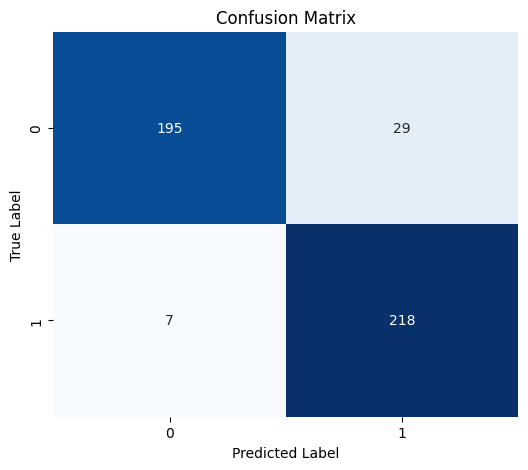

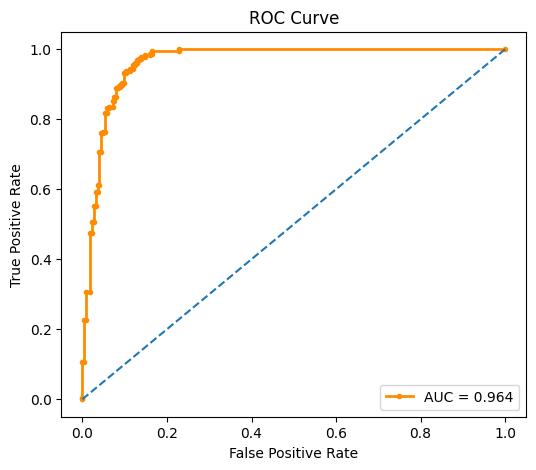

In [12]:
matrix = confusion_matrix(y_test, y_test_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# If binary classification, generate ROC curve and calculate AUC
if len(set(y)) == 2:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, marker='.', color='darkorange', lw=2, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [13]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("Accuracy:", accuracy) # considerar mais quando o dataset é balanceado
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9198218262806236
Precision: 0.8825910931174089
Recall: 0.9688888888888889
F1 Score: 0.923728813559322


In [14]:
# Guardar o modelo:
pickle.dump(model, open('modelo_cdhit.pkl', 'wb'))

# Carregar o modelo guardado
loaded_model = pickle.load(open('modelo_cdhit.pkl', 'rb'))
loaded_model

Pipeline(steps=[('imputer', SimpleImputer()), ('selector', SelectKBest(k=25)),
                ('scaler', StandardScaler()), ('pca', PCA()),
                ('logr', LogisticRegression(max_iter=10000))])